# 🌺 고객 대출등급 분류 해커톤 - HYPERPARAMETER
Evaluation Metric : Macro F1<br>
Public Score : 전체 테스트 데이터 중 30%<br>
Feature add score : 0.91, 0.92점대로 마감하기!

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from sklearn.model_selection import cross_val_score, train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [84]:
def load_dataset():
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')
    all_df = pd.concat([train,test])
    return all_df

def to_num(value):
    try:
        return int(value.split()[0])
    except ValueError:
        if value in ('10+ years','10+yea|rs'):
            return 10
        elif value in ('< 1 year','<1 year'):
            return 0
        else:
            return np.nan

def working_period_to_num(df):
    df['근로기간'] = df['근로기간'].apply(to_num)
    return df

def upper_limit_95(df, columns):
    for col in columns:
        per95 = df[col].quantile(0.95)
        df[col] = df[col].apply(lambda x : per95 if x > per95 else x)


def feature_create(df):

    #1
    df['연체여부'] = df['총연체금액'].apply(lambda x : 1 if x!=0 else 0)
    df['연체계좌여부'] = df['연체계좌수'].apply(lambda x : 1 if x!=0 else 0)
    
    df['상환비율'] = df['총상환원금']/df['대출금액']
    df['상환이자비율'] = df['총상환이자']/df['대출금액']
    df['상환원금이자비율'] = df['총상환원금']/(df['총상환이자']+1)
    
    #2
    qu3 = int(df['대출금액'].quantile(0.3))
    df['대출금액상한액지정'] = df['대출금액'].apply(lambda x : qu3 if x > qu3 else x)
    
    df['장기근로자'] = df['근로기간'].apply(lambda x: 0 if x < 10 else 1)
    
    #4
    df['월상환금액'] = df['대출금액']/df['대출기간'].apply(lambda x : 36 if x == ' 36 months' else 60)/100000
    df['월상환금액'] = np.ceil(df['월상환금액']).astype(int)
    
    return df

def feature_preprocessing(df):
    
    # 상한설정
    limit_col = ['연간소득','총계좌수','부채_대비_소득_비율',
                 '총상환원금','총상환이자','상환원금이자비율']
    upper_limit_95(df, limit_col)
    
    # 라벨 인코딩
    to_label_col = ['대출기간', '주택소유상태', '대출목적']
    for col in to_label_col:
        df[col] = pd.factorize(df[col])[0]
        
    # 불필요한 실수를 정수형으로    
    to_int_col = ['연간소득','총계좌수','총상환이자','총연체금액',
                  '연체계좌수','최근_2년간_연체_횟수','총상환원금']
    df[to_int_col] = df[to_int_col].astype(int)
    
    return df

def dataset_line():
    
    df = load_dataset()
    working_period_to_num(df)
    feature_create(df)
    feature_preprocessing(df)
    
    return df

def model_train(df, params):
    train = df[~df['대출등급'].isnull()]
    test = df[df['대출등급'].isnull()].drop('대출등급',axis=1)
    
    X = train.drop(['ID','대출등급'], axis=1)
    y = train['대출등급']

    xt, xv, yt, yv = train_test_split(X,y,
                                     test_size = 0.25,
                                     random_state = 2024)
    
    model = LGBMClassifier(**params, verbose = -1)
    model.fit(xt, yt, eval_set = [(xt,yt),(xv,yv)],
              eval_metric = 'multi_logloss',
              callbacks = [lgb.early_stopping(stopping_rounds=50), 
                          lgb.log_evaluation(period=100)])
    
    return model, test

In [83]:
# 4옵션 조건
params = {'n_estimators': 1000,
          'learning_rate': 0.01,
          'colsample_bytree': 0.5, 
          'max_bin': 511, 
          'max_depth': 20, 
          'min_child_samples': 28, 
          'min_child_weight': 1, 
          'num_leaves': 64, 
          'reg_alpha': 0.01, 
          'reg_lambda': 0.001, 
          'subsample': 0.7851}

In [38]:
# 3옵션했을떄
params = {'n_estimators': 1000,
          'learning_rate': 0.01,
          'colsample_bytree': 0.5,
          'max_bin': 500, 
          'max_depth': 10, 
          'min_child_samples': 105, 
          'min_child_weight': 1, 
          'num_leaves': 64,
          'reg_alpha': 0.01, 
          'reg_lambda': 0.001, 
          'subsample': 1.0}

In [85]:
df = dataset_line()
model, test = model_train(df, params)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.40627	valid_1's multi_logloss: 0.416241
[200]	training's multi_logloss: 0.191776	valid_1's multi_logloss: 0.209082
[300]	training's multi_logloss: 0.13017	valid_1's multi_logloss: 0.155478
[400]	training's multi_logloss: 0.102938	valid_1's multi_logloss: 0.136819
[500]	training's multi_logloss: 0.0887046	valid_1's multi_logloss: 0.131952
[600]	training's multi_logloss: 0.078408	valid_1's multi_logloss: 0.130551
[700]	training's multi_logloss: 0.070103	valid_1's multi_logloss: 0.129902
Early stopping, best iteration is:
[729]	training's multi_logloss: 0.0679993	valid_1's multi_logloss: 0.129778


In [ ]:
# [611]	training's multi_logloss: 0.0756473	valid_1's multi_logloss: 0.136416 3옵션까지 넣었을 때
# [453]	training's multi_logloss: 0.0749756	valid_1's multi_logloss: 0.136327 학습률 0.027

# 2파람으로 2돌렸을때
# [680]	training's multi_logloss: 0.0714743	valid_1's multi_logloss: 0.136183 학습률0.02
# 3파람으로 2돌렸을때
# [519]	training's multi_logloss: 0.0630685	valid_1's multi_logloss: 0.130171 학습률0.02
# [989]	training's multi_logloss: 0.0655046	valid_1's multi_logloss: 0.130099 학습률 0.01

# 4파람으로 0.01돌렸을떄
# [645]	training's multi_logloss: 0.082458	valid_1's multi_logloss: 0.131714
# [264]	training's multi_logloss: 0.0731801	valid_1's multi_logloss: 0.133678 학습률 0.03

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160491 entries, 0 to 64196
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            160491 non-null  object 
 1   대출금액          160491 non-null  int64  
 2   대출기간          160491 non-null  int64  
 3   근로기간          149446 non-null  float64
 4   주택소유상태        160491 non-null  int64  
 5   연간소득          160491 non-null  int32  
 6   부채_대비_소득_비율   160491 non-null  float64
 7   총계좌수          160491 non-null  int32  
 8   대출목적          160491 non-null  int64  
 9   최근_2년간_연체_횟수  160491 non-null  int32  
 10  총상환원금         160491 non-null  int32  
 11  총상환이자         160491 non-null  int32  
 12  총연체금액         160491 non-null  int32  
 13  연체계좌수         160491 non-null  int32  
 14  대출등급          96294 non-null   object 
 15  연체여부          160491 non-null  int64  
 16  연체계좌여부        160491 non-null  int64  
 17  상환비율          160491 non-null  float64
 18  상환이자비

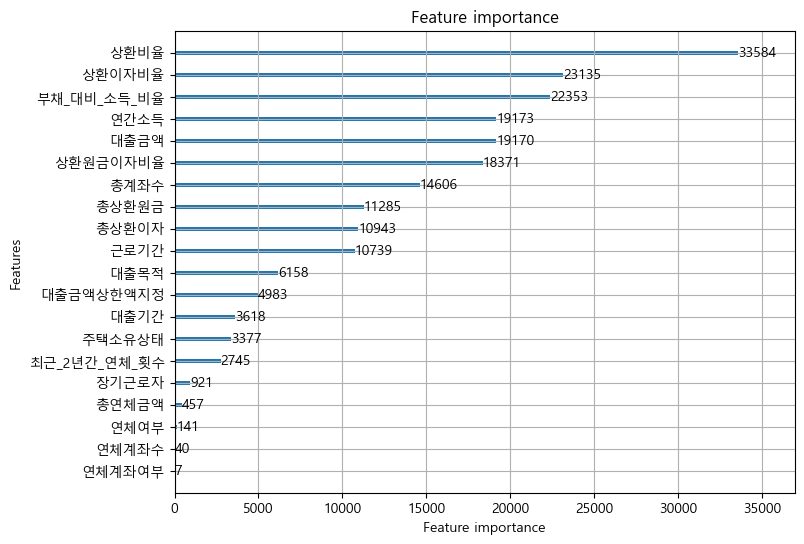

In [11]:
from lightgbm import plot_importance
plot_importance(model, figsize=(8, 6))
plt.show()

In [5]:
id_list = test['ID']
pred = model.predict(test.drop(['ID'],axis=1))
pred

array(['B', 'B', 'A', ..., 'D', 'C', 'A'], dtype=object)

In [6]:
dic = {'ID' : id_list,
      '대출등급' : pred}
result = pd.DataFrame(dic)

In [8]:
result.to_csv('submit04.csv',index=False)

## ● 베이지안 최적화

In [77]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import log_loss

In [78]:
df = dataset_line()

In [79]:
train = df[~df['대출등급'].isnull()]
test = df[df['대출등급'].isnull()].drop('대출등급',axis=1)

X = train.drop(['ID','대출등급'], axis=1)
y = train['대출등급']

label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F':5, 'G':6}
y = y.map(label_mapping)

xt, xv, yt, yv = train_test_split(X,y,
                                 test_size = 0.25,
                                 random_state = 2024)

In [80]:
bayesian_params = {
    'max_depth' : (10, 20),
    'num_leaves' : (24, 64),
    'min_child_samples' : (10, 200),
    'min_child_weight' : (1, 20),
    'subsample' : (0.5, 1),
    'colsample_bytree' : (0.5, 1),
    'max_bin' : (200, 600),
    'reg_lambda' : (0.001, 10),
    'reg_alpha' : (0.01, 50),
}

In [81]:
def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators": 500, "learning_rate": 0.02,
        "max_depth" : int(round(max_depth)),
        "num_leaves" : int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample' : max(min(subsample, 1), 0), # 범위를 지정
        'colsample_bytree' : max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMClassifier(**params, verbose=-1)
    lgb_model.fit(xt, yt, eval_set=[(xt, yt), (xv, yv)], 
                  eval_metric= 'multi_logloss',
                  callbacks=[lgb.early_stopping(stopping_rounds=50),
                             lgb.log_evaluation(period = 100)])
    valid_proba = lgb_model.predict_proba(xv)
    loss = log_loss(yv, valid_proba)
    
    return -loss

In [82]:
lgbBO = BayesianOptimization(lgb_roc_eval, pbounds=bayesian_params, 
                             random_state = 2024)
lgbBO.maximize(init_points = 5, n_iter = 25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.285395	valid_1's multi_logloss: 0.287275
[200]	training's multi_logloss: 0.193677	valid_1's multi_logloss: 0.197571
[300]	training's multi_logloss: 0.179494	valid_1's multi_logloss: 0.184473
[400]	training's multi_logloss: 0.173406	valid_1's multi_logloss: 0.17888
[500]	training's multi_logloss: 0.171052	valid_1's multi_logloss: 0.176782
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.171052	valid_1's multi_logloss: 0.176782
| 1         | -0.1768   | 0.794     | 479.6     | 11.88     | 18.32     | 4.895     | 28.24     | 36.36     | 6.794     | 0.7369    |
Training until validation scores don't i

KeyboardInterrupt: 

In [ ]:
lgbBO.res

In [47]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

[-0.17447816157644666, -0.1857556036890109, -0.1525750793410783, -0.16453898172965917, -0.16909034007103807, -0.15646009698703978, -0.14403508941271917, -0.16021842177857162, -0.1619839376301834, -0.18302181057293265, -0.13548622915836142, -0.14127050299416377, -0.1381387403266466, -0.142895862545821, -0.14397318188362335, -0.14167264569421537, -0.13630048733935896, -0.13901599630013683, -0.18980931788284627, -0.1460010116071159, -0.1422116106400921, -0.13831879005249081, -0.13570090542815177, -0.1439938319260037, -0.14250032007612712, -0.13324421540680514, -0.13143855076855795, -0.18552930662486766, -0.14239018148705412, -0.14572532118161935]
maximum target index: 26


In [48]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

{'target': -0.13143855076855795, 'params': {'colsample_bytree': 1.0, 'max_bin': 640.0, 'max_depth': 20.0, 'min_child_samples': 17.575095690198545, 'min_child_weight': 6.3500102220793835, 'num_leaves': 57.00123623230496, 'reg_alpha': 0.01, 'reg_lambda': 0.001, 'subsample': 0.5}}


## ● OOF

In [27]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(df, nfolds=5):
    train = df[~df['대출등급'].isnull()]
    test = df[df['대출등급'].isnull()].drop('대출등급',axis=1)
    
    X = train.drop(['ID','대출등급'], axis=1)
    y = train['대출등급']

    folds = KFold(n_splits=nfolds, shuffle=True, random_state=2024)
    
    oof_preds = np.zeros((train.shape[0], 7))  
    test_preds = np.zeros((test.shape[0], 7))
    
    clf = LGBMClassifier(
                n_estimators=2000,
                learning_rate=0.01,
                colsample_bytree = 0.5,
                max_bin= 500, 
                max_depth= 10, 
                min_child_samples= 105, 
                min_child_weight= 1, 
                num_leaves= 64,
                reg_alpha= 0.01, 
                reg_lambda= 0.001, 
                subsample= 1.0,
                verbose= -1,
                )

    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print('##### iteration ', fold_idx, ' 시작')
        train_x  = X.iloc[train_idx, :]
        train_y = y.iloc[train_idx]
        valid_x = X.iloc[valid_idx, :]
        valid_y = y.iloc[valid_idx]
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'multi_logloss', 
                callbacks = [lgb.early_stopping(stopping_rounds=200), 
                             lgb.log_evaluation(period=100)])
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)       
        test_preds += clf.predict_proba(test.drop('ID', axis=1), num_iteration=clf.best_iteration_)/folds.n_splits
        
    return clf, test_preds

In [28]:
clf, test_preds = train_apps_all_with_oof(df)

##### iteration  0  시작
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 0.441203	valid_1's multi_logloss: 0.448342
[200]	training's multi_logloss: 0.219191	valid_1's multi_logloss: 0.231331
[300]	training's multi_logloss: 0.147203	valid_1's multi_logloss: 0.164709
[400]	training's multi_logloss: 0.117941	valid_1's multi_logloss: 0.141833
[500]	training's multi_logloss: 0.103824	valid_1's multi_logloss: 0.135764
[600]	training's multi_logloss: 0.0934921	valid_1's multi_logloss: 0.133115
[700]	training's multi_logloss: 0.0852221	valid_1's multi_logloss: 0.131937
[800]	training's multi_logloss: 0.078345	valid_1's multi_logloss: 0.131281
[900]	training's multi_logloss: 0.0724163	valid_1's multi_logloss: 0.130918
[1000]	training's multi_logloss: 0.0670982	valid_1's multi_logloss: 0.130572
[1100]	training's multi_logloss: 0.0624589	valid_1's multi_logloss: 0.130701
[1200]	training's multi_logloss: 0.0582576	valid_1's multi_logloss: 0.130967
Early 

In [29]:
test_preds

array([[3.87214673e-04, 9.98373617e-01, 1.08537502e-03, ...,
        2.41813110e-05, 3.76334375e-06, 6.50367211e-07],
       [2.24821564e-01, 4.72611492e-01, 2.10682362e-01, ...,
        1.44363594e-02, 2.10341918e-03, 2.18745927e-05],
       [9.97398890e-01, 2.19610266e-03, 2.67402113e-04, ...,
        2.12809745e-05, 1.41734252e-06, 1.10167148e-06],
       ...,
       [1.87863068e-04, 5.72454208e-04, 1.09408847e-03, ...,
        6.22011194e-04, 9.28325933e-06, 7.96426009e-06],
       [7.44048607e-05, 1.49560063e-03, 9.90457399e-01, ...,
        2.99120059e-04, 3.22587449e-05, 7.29930183e-06],
       [9.74774677e-01, 2.30475271e-02, 5.61740587e-04, ...,
        1.32518623e-04, 1.82664700e-05, 3.96002261e-06]])

In [32]:
label_mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G'}
pred = []

for i in range(test_preds.shape[0]):
    label_idx = np.argmax(test_preds[i])
    label = label_mapping[label_idx]
    pred.append(label)

In [35]:
len(pred)

64197

In [86]:
pred = model.predict_proba(test)

ValueError: Number of features of the model must match the input. Model n_features_ is 21 and input n_features is 22

In [36]:
id_list = test['ID']
dic = {'ID' : id_list,
      '대출등급' : pred}
result = pd.DataFrame(dic)

In [38]:
result.to_csv('submit05.csv',index=False)